In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
movies_df = pd.read_csv("data/movies.csv")
ratings_df = pd.read_csv("data/ratings.csv")

# Quick check of missing values and data types
print("Movies Missing Values:\n", movies_df.isnull().sum())
print("Ratings Missing Values:\n", ratings_df.isnull().sum())

# Convert genres string into a list
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))

# Display first few rows of movies data
print("Movies DataFrame:")
print(movies_df.head())


Movies Missing Values:
 movieId    0
title      0
genres     0
dtype: int64
Ratings Missing Values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                              genres  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]  


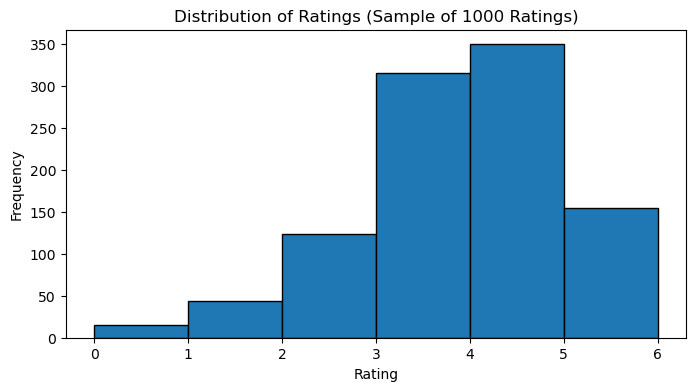

In [4]:
# Sample 1,000 ratings for visualization
sample_ratings = ratings_df.sample(1000, random_state=42)

plt.figure(figsize=(8, 4))
plt.hist(sample_ratings['rating'], bins=[0, 1, 2, 3, 4, 5, 6], edgecolor='black')
plt.title("Distribution of Ratings (Sample of 1000 Ratings)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


Average Rating per Genre:
                 Genre  Avg Rating
0   (no genres listed)    3.368157
1               Action    3.476407
2            Adventure    3.523439
3            Animation    3.615332
4             Children    3.439241
5               Comedy    3.432386
6                Crime    3.691771
7          Documentary    3.691182
8                Drama    3.682454
9              Fantasy    3.512175
10           Film-Noir    3.915774
11              Horror    3.307155
12                IMAX    3.593312
13             Musical    3.554277
14             Mystery    3.673103
15             Romance    3.545003
16              Sci-Fi    3.491699
17            Thriller    3.531702
18                 War    3.791699
19             Western    3.600175


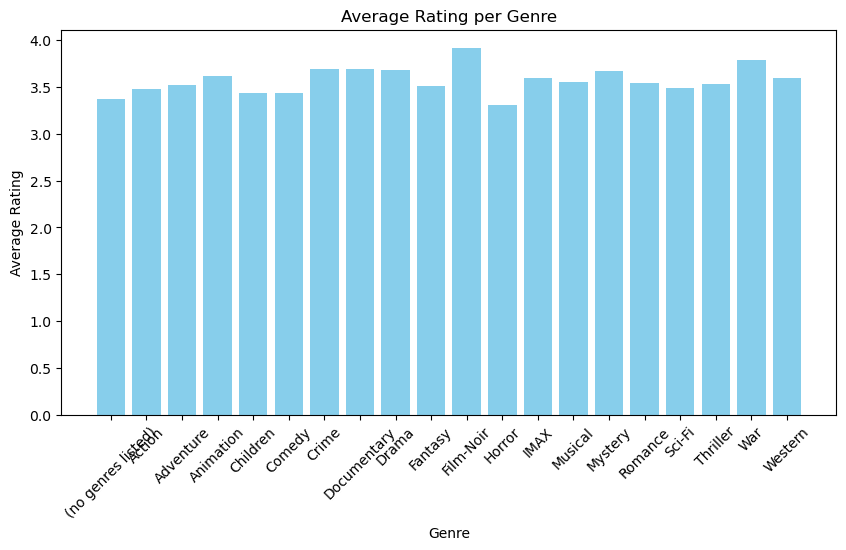

In [6]:
# Merge movies and ratings datasets
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Explode the genres column to have one row per genre per movie
exploded_df = merged_df.explode('genres')

# Compute average rating per genre using groupby on the exploded DataFrame
genre_avg_df = exploded_df.groupby('genres')['rating'].mean().reset_index()
genre_avg_df.columns = ['Genre', 'Avg Rating']

print("Average Rating per Genre:")
print(genre_avg_df)

# Plot average rating per genre
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(genre_avg_df['Genre'], genre_avg_df['Avg Rating'], color='skyblue')
plt.title("Average Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

# One-Hot Encoding: Transform genres into binary features
mlb = MultiLabelBinarizer()
genres_onehot = mlb.fit_transform(movies_df['genres'])
genres_df = pd.DataFrame(genres_onehot, columns=mlb.classes_)
movies_df = pd.concat([movies_df, genres_df], axis=1)

# Merge movies and ratings
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Build user profiles: average rating per genre
user_profiles = {}
for genre in mlb.classes_:
    genre_ratings = merged_df[merged_df[genre] == 1]
    avg_ratings = genre_ratings.groupby('userId')['rating'].mean()
    user_profiles[genre] = avg_ratings

user_profiles = pd.DataFrame(user_profiles).fillna(0)
print("User Profiles (First 5 Users):")
print(user_profiles.head())


User Profiles (First 5 Users):
        (no genres listed)    Action  Adventure  Animation  Children  \
userId                                                                 
1                      0.0  4.105263   3.470588   0.000000  3.500000   
2                      0.0  3.888889   4.142857   4.875000  4.727273   
3                      0.0  3.560345   3.620690   3.958333  3.775000   
4                      0.0  2.454545   3.400000   0.000000  0.000000   
5                      0.0  3.642857   3.461538   3.666667  3.500000   

          Comedy     Crime  Documentary     Drama   Fantasy  Film-Noir  \
userId                                                                   
1       3.333333  3.875000          3.0  3.549020  2.500000        5.0   
2       4.000000  3.500000          0.0  4.458333  4.750000        0.0   
3       3.203704  3.406250          0.0  4.169811  3.117647        0.0   
4       3.142857  2.000000          0.0  2.375000  3.333333        0.0   
5       3.000000  2.

In [ ]:
import numpy as np

# Cosine similarity function
def cosine_similarity(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Recommendation function
def recommend_movies(user_id, candidate_movies_df, user_profiles, genre_columns, top_n=5):
    user_vector = user_profiles.loc[user_id].values
    scores = []
    for idx, row in candidate_movies_df.iterrows():
        movie_vector = row[genre_columns].values
        score = cosine_similarity(user_vector, movie_vector)
        scores.append(score)
    candidate_movies_df = candidate_movies_df.copy()  # To avoid modifying original DataFrame
    candidate_movies_df['score'] = scores
    recommendations = candidate_movies_df.sort_values(by='score', ascending=False)
    return recommendations[['movieId', 'title', 'score']].head(top_n)


